In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sentiment_data = pd.read_csv("IMDB Dataset.csv")
sentiment_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
sentiment_data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


- Analyse Exploratoire des Données

In [6]:
sentiment_data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [7]:
sentiment_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

On voit que les données sont bien équilibrées

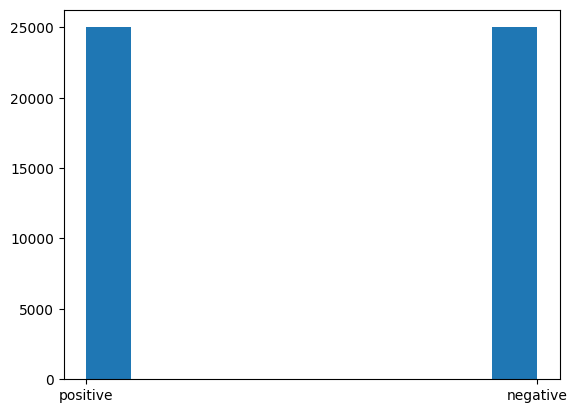

In [8]:
plt.hist(sentiment_data['sentiment'])
plt.show()
# On voit que les données sont bien équilibrées

In [9]:
# dimensions du dataset
sentiment_data.shape

(50000, 2)

Nettoyage du dataset

In [48]:
import re

def nettoyer_dataset(df):
    # Supprimer les doublons
    df = df.drop_duplicates()
    # Supprimer les valeurs manquantes
    df = df.dropna()
    # Nettoyer le texte des reviews (enlever balises HTML, caractères spéciaux, etc.)
    def nettoyer_texte(texte):
        texte = re.sub(r'<.*?>', '', texte)  # enlever balises HTML
        texte = re.sub(r'[^a-zA-Z0-9\s]', '', texte)  # enlever caractères spéciaux
        texte = texte.lower()  # mettre en minuscule
        return texte.strip()
    df['review'] = df['review'].apply(nettoyer_texte)
    return df

In [11]:
sentiment_data = nettoyer_dataset(sentiment_data)
sentiment_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


Transformons les commentaires en Token en utilisant ngram pour combiner les mots et non token simple et ignoré les mots en 
anglais qui ne sont pas utilent

In [12]:
STOPWORDS = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them",
    "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those",
    "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having",
    "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because",
    "as", "until", "while", "of", "at", "by", "for", "with", "about", "against",
    "between", "into", "through", "during", "before", "after",  "above", "below", "to", "from",
    "up", "down", "in", "out", "on", "off"
])

def tokenizer(texte,ngram_range=(1,1)):
    texte = texte.lower()
    tokens = re.findall(r'\b\w+\b', texte) 
    tokens = [token for token in tokens if token not in STOPWORDS]
    
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams += [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        
    return ngrams

In [13]:
tokenizer("I thought this movie did a down right good job")

['thought', 'movie', 'right', 'good', 'job']

Construction de vocabulaire pour le NLP avec ngram pour les mots les plus frequents

In [14]:
from collections import Counter 

def build_vocab(df,ngram_range=(1,1),n_max=5000): 
    freq = Counter()
    for review in df['review']:
        tokens = tokenizer(review, ngram_range)
        freq.update(tokens) 
        
    # print(freq) 
    vocab = {word: i for i, (word,_) in enumerate(freq.most_common(n_max))}
    
    return vocab
    

In [15]:
v = build_vocab(sentiment_data)

Calcul de IDF à la main (les mots les plus importants). 
Plus un mot est frequent moins il est important

In [16]:
from collections import defaultdict 

def computer_idf(docs, vocab, ngram_range=(1,1)):
    N = len(docs)
    df = defaultdict(int) 
    
    for doc in docs:
        tokens = tokenizer(doc, ngram_range)
        for token in tokens:
            if token in vocab:
                df[token] += 1 
                
    idf = {word: np.log((N+1) / (df[word] + 1))+1 for word in vocab}           
    return idf

    
    

In [17]:
idf = computer_idf(["I thought this,good movie did a down right good job"],v)

Vectorisation TF-IDF + Normalisation (ie transformation de dataset en espace vectoriel) L2 à la main

In [18]:
from sklearn.preprocessing import normalize

def vectorize_tfidf(doc, vocab, idf, ngram_range=(1,1)):
    tokens = tokenizer(doc[0], ngram_range)
    tf = Counter(tokens)        # calcul de frequence dans une phrase
    vec = np.zeros(len(vocab))
    for token in tokens:
        if token in vocab:
            i = vocab[token]   # index du mot dans le vocabulaire {word: index}
            vec[i] = tf[token] * idf[token]
    vec = normalize(vec.reshape(1, -1))[0]   # normalisation L2
    return vec
    
    
# Créaton de la matrice TF-IDF pour tout le dataset (tous les vecteurs du dataset)

def tfidf_transform(docs, vocab, idf, ngram_range=(1,1)): 
    x = np.array([vectorize_tfidf([doc], vocab, idf, ngram_range) for doc in docs])
    return x
    

Partie Modelisation: détection d'émotion

In [19]:
vocab = build_vocab(sentiment_data, ngram_range=(1,2), n_max=5500)
idf = computer_idf(sentiment_data['review'], vocab, ngram_range=(1,2))
data_vectorized = tfidf_transform(sentiment_data['review'], vocab, idf, ngram_range=(1,2))

In [20]:
data_vectorized.shape

(49582, 5500)

Encodage de "sentiment"

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(sentiment_data['sentiment'])

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_vectorized, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Exemple avec une régression logistique et validation croisée à 5 folds
clf = LogisticRegression(max_iter=1000)  # s'il y a déséquilibre, ajouter class_weight='balanced' à l'interieur de LogisticRegression
scores = cross_val_score(clf, data_vectorized, y, cv=5, scoring='accuracy')
print("Scores de validation croisée (accuracy) :", scores)
print("Score moyen :", scores.mean())

Scores de validation croisée (accuracy) : [0.89875971 0.89724715 0.89269867 0.89572408 0.89532069]
Score moyen : 0.8959500603699695


In [24]:
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [25]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = clf.predict(X_test) 
print("Accuracy =", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy = 0.8943228799031965
              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      4939
    positive       0.88      0.91      0.90      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [26]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC(max_iter=1000)
scores = cross_val_score(svm_model, data_vectorized, y, cv=5, scoring='accuracy')
print("Scores de validation croisée (accuracy) :", scores)
print("Score moyen :", scores.mean())

Scores de validation croisée (accuracy) : [0.8910961  0.89069275 0.88584106 0.88866478 0.88816055]
Score moyen : 0.8888910490349449


In [27]:
svm_model.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [28]:
y_pred = svm_model.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy = 0.8856509024906726
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4939
    positive       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
scores_rf = cross_val_score(rf_model, data_vectorized, y, cv=5, scoring='accuracy')
print("Scores de validation croisée (accuracy) :", scores_rf)
print("Score moyen :", scores_rf.mean())

Scores de validation croisée (accuracy) : [0.84440859 0.85136634 0.84519968 0.84822509 0.84862848]
Score moyen : 0.8475656358424377


In [30]:
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
y_pred_rf = rf_model.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Accuracy = 0.8432993848946254
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4939
    positive       0.84      0.84      0.84      4978

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



- Pour ngram_range=(1,1), nous avons: svm_model: 0.88, clf: 0.89 
- Pour ngram_range=(1,2), nous avons: svm_model: 0.885, clf: 0.894, rf_model: 0.843

Enrégistrement du meilleur modèle

In [32]:
import pickle
# Enrégistrement du meilleur modèle
with open('logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf, f)

Chargement du modèle

In [33]:
with open('logistic_regression.pkl', 'rb') as f:
    clf = pickle.load(f)

La fonction qui permet de faire la prédiction des émotions

In [49]:
def predire_emotion(text_input, clf=clf, vocab=vocab, idf=idf, le=le, ngram_range=(1,2)):
    # Nettoyer le texte (en utilisant la fonction interne de nettoyage)
    def nettoyer_texte(texte):
        texte = re.sub(r'<.*?>', '', texte)
        texte = re.sub(r'[^a-zA-Z0-9\s]', '', texte)
        texte = texte.lower()
        return texte.strip()
    text = nettoyer_texte(text_input)
    # Vectoriser le texte
    vec = vectorize_tfidf([text], vocab, idf, ngram_range)
    # Prédire
    pred = clf.predict(vec.reshape(1, -1))
    return le.inverse_transform(pred)[0]

In [50]:
predire_emotion("I really loved this movie. It was fantastic and thrilling!")

'positive'

Pipeline des utilisateurs qui permet de saisir une phrase et la prédiction donne l'émotion

In [56]:
print("Entrez une phrase pour analyser le sentiment (ou 'exit' pour quitter) :")
while True:
    user_input = input(">> ")
    if user_input.lower() == 'exit':
        break
    prediction = predire_emotion(user_input, clf, vocab, idf)   
    print(f"Sentiment prédit : {prediction}")

Entrez une phrase pour analyser le sentiment (ou 'exit' pour quitter) :
